In [1]:
#%pip install datasets
%pip install transformers
%pip install evaluate
%pip install huggingface_hub

For datasets, there are a lot of issues with the version type when running on a cuda core, a guranteed safe
way to run is on a cpu, hence it is left commented out first.  If it throws an error, reinstall dataset OR update with %pip install -U datasets, then run load_dataset again in line 36 and 37. 

If it still doesn't work, update datasets again, clear all outputs, and re-comment out the %pip install -U datasets line before running all again. The correct output for bloc 5 is the image with the notebooks


In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
import numpy as np
import torch

# Set random seed for NumPy
np.random.seed(28)

# Set random seed for PyTorch
torch.manual_seed(28)

# Set random seed for PyTorch CUDA (if available)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(28)
    
# Set random seed for the transformer model
from transformers import set_seed
set_seed(28)


2024-04-09 09:10:45.102455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 09:10:45.102507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 09:10:45.103982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#To access the model and datasets in a format, login below. API is in readme.
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from datasets import load_dataset # Used to load data from hugging face repositry, if error, see the markdown above. 
raw_datasets = load_dataset('J3nsenn/Output-features_10k')
raw_datasets



DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 2000
    })
})

In [6]:
#Tokenizing the text data
from transformers import AutoTokenizer, DataCollatorWithPadding
raw_datasets = load_dataset('J3nsenn/Output-features_10k')
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['text'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
x = 'Hello everyone!' # This is just to see the format of input_ids and attention_masks
tokenized2  = tokenizer(x)
print(tokenized2)

{'input_ids': [101, 7592, 3071, 999, 102], 'attention_mask': [1, 1, 1, 1, 1]}


# Tokenizing the datasets, and preparing the dataloader for test and eval set

In [8]:
#Check that label, input_ids & attenion_mask are present
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [9]:
#Remove irrelevant columns to only have 3 taken in by the model
tokenized_datasets = tokenized_datasets.remove_columns(["Unnamed: 0","text",])

tokenized_datasets.set_format("torch")
print(tokenized_datasets["train"].column_names)
print(tokenized_datasets["test"].column_names)
print(tokenized_datasets["validation"].column_names)

['label', 'input_ids', 'attention_mask']
['label', 'input_ids', 'attention_mask']
['label', 'input_ids', 'attention_mask']


In [10]:
#Run for training model and evaluation set only, test dataset is in other folder
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [11]:

for batch in train_dataloader: # change to test_loader, eval_loder or train_loader based on what you wish to check
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512]),
 'labels': torch.Size([8])}

# Model Training Begins Here

In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
#Small test run 
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.6997, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


In [14]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

2250


In [16]:
#Run this to ensure model and tensors are on the same device
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [17]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Remaining code remains the same as before

# Initialize tqdm progress bar
progress_bar = tqdm(range(num_training_steps))

# Initialize lists to store training loss and accuracy values
train_losses = []
train_accuracies = []

# Inside the training loop
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Compute accuracy and store loss and accuracy values
        train_losses.append(loss.item())
        train_accuracies.append((outputs.logits.argmax(dim=-1) == batch["labels"]).float().mean().item())

        progress_bar.update(1)



  0%|          | 0/2250 [00:00<?, ?it/s]

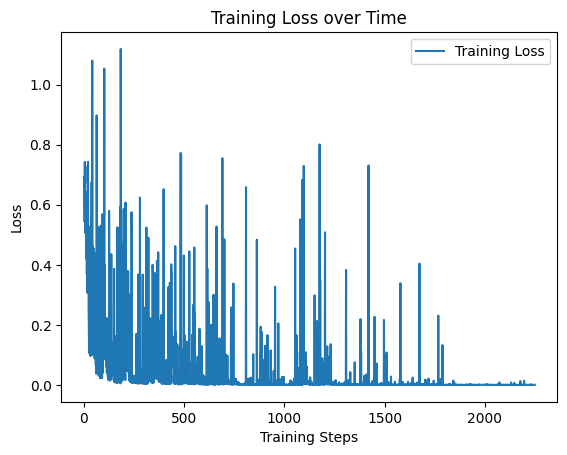

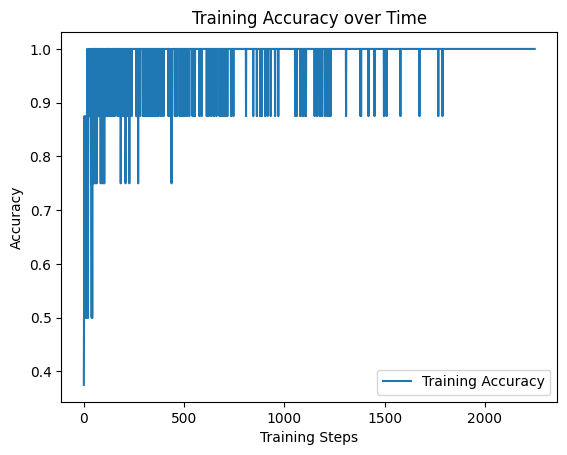

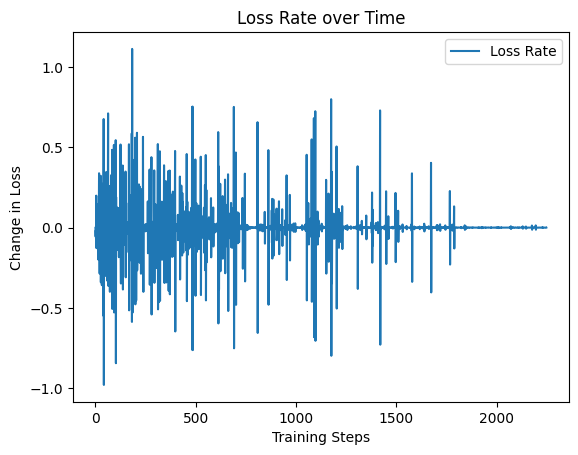

In [18]:

# Plotting training loss
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.legend()
plt.savefig('training_loss.png')
plt.show()

# Plotting training accuracy
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Time")
plt.legend()
plt.savefig('training_accuracy.png')
plt.show()

# Plotting loss rate (change in loss over training steps)
loss_rate = [train_losses[i] - train_losses[i-1] for i in range(1, len(train_losses))]
plt.plot(loss_rate, label="Loss Rate")
plt.xlabel("Training Steps")
plt.ylabel("Change in Loss")
plt.title("Loss Rate over Time")
plt.legend()
plt.savefig('training_loss_overtime.png')
plt.show()


# Upload to huggingface repo

This line of code has been commented out to prevent accidental replacement of the model on hugging face repo

In [29]:
#model.push_to_hub("fine-tuned-distilbertv3") #v1 was what we used in our class presentation, when i haven't added the random seed. v3 has seed fixed to 28

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/J3nsenn/fine-tuned-distilbertv3/commit/239801435acee033e4cce01b83878c0c74eca000', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='239801435acee033e4cce01b83878c0c74eca000', pr_url=None, pr_revision=None, pr_num=None)

# Evaluation Metrics


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [23]:
#Evaluation code with plots
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Assuming your validation dataset is in a DataLoader named eval_dataloader
# Prepare lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
eval_losses = []
eval_accuracies = []

# Set model to evaluation mode
model.eval()

# Initialize tqdm progress bar
progress_bar = tqdm(eval_dataloader, desc="Evaluating")

# Iterate over the validation dataset
for batch in progress_bar:
    with torch.no_grad():
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch)
        logits = outputs.logits
        
        # Get predicted labels
        _, predicted = torch.max(logits, dim=1)
        
        # Append true labels and predicted labels to lists
        true_labels.extend(batch['labels'].cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        # Compute evaluation loss
        eval_loss = outputs.loss.item()
        eval_losses.append(eval_loss)
        
        # Compute evaluation accuracy
        eval_accuracy = accuracy_score(batch['labels'].cpu().numpy(), predicted.cpu().numpy())
        eval_accuracies.append(eval_accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print or visualize the confusion matrix and metrics
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]

Confusion Matrix:
[[1262    3]
 [  13  722]]
Accuracy: 0.992
Precision: 0.9920302907369843
Recall: 0.992
F1-score: 0.991988350771222


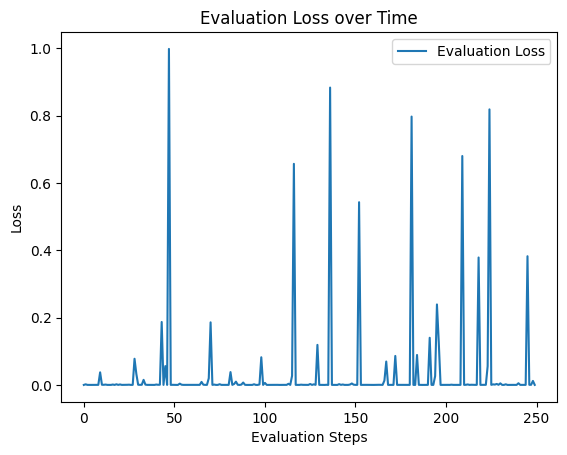

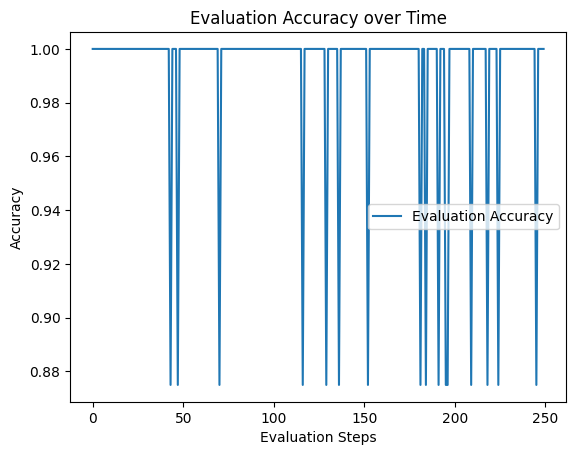

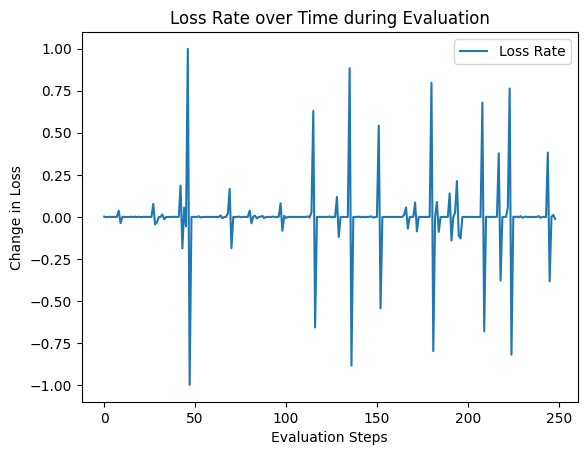

In [24]:

# Plotting evaluation loss
plt.plot(eval_losses, label="Evaluation Loss")
plt.xlabel("Evaluation Steps")
plt.ylabel("Loss")
plt.title("Evaluation Loss over Time")
plt.legend()
plt.savefig('Evaluation Loss over Time.png')
plt.show()

# Plotting evaluation accuracy
plt.plot(eval_accuracies, label="Evaluation Accuracy")
plt.xlabel("Evaluation Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy over Time")
plt.legend()
plt.savefig('Evaluation Accuracy over Time.png')
plt.show()

# Plotting loss rate (change in loss over evaluation steps)
loss_rate = [eval_losses[i] - eval_losses[i-1] for i in range(1, len(eval_losses))]
plt.plot(loss_rate, label="Loss Rate")
plt.xlabel("Evaluation Steps")
plt.ylabel("Change in Loss")
plt.title("Loss Rate over Time during Evaluation")
plt.legend()
plt.savefig('Loss Rate over Time during Evaluation.png')
plt.show()


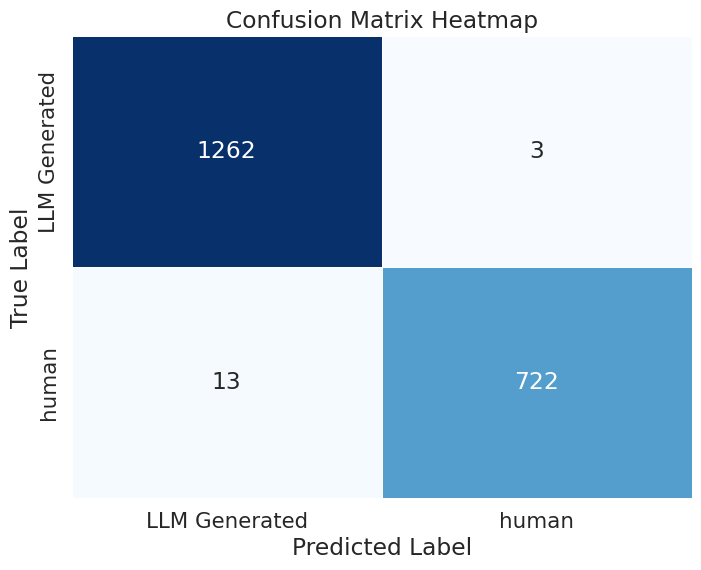

In [25]:
# Plotting the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set_theme(font_scale=1.4)  # Adjust font size if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['LLM Generated', 'human'],  # Replace with your class labels
            yticklabels=['LLM Generated', 'human'],  # Replace with your class labels
            linewidths=.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()